### import library, data and selected features

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
from imblearn.under_sampling import RandomUnderSampler

# import package for model building
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier


from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, recall_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.models import load_model
from keras.utils.np_utils import to_categorical



# import cleaned dataset
accepted_cleaned = pd.read_csv('./cleaned dataset V2.csv')
accepted_cleaned.drop(columns=['Unnamed: 0','addr_state'],inplace=True)
accepted_cleaned.head()

# adjust the import error
accepted_cleaned['term'] = accepted_cleaned['term'].str.strip()
# remove the columns with only 1 value.
accepted_cleaned = accepted_cleaned.drop(columns = ['out_prncp', 'pymnt_plan'])

/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
accepted_cleaned.loan_status.value_counts()

0    1992069
1     268599
Name: loan_status, dtype: int64

In [3]:
accepted_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2260668 entries, 0 to 2260667
Data columns (total 72 columns):
 #   Column                      Dtype  
---  ------                      -----  
 0   loan_amnt                   float64
 1   term                        object 
 2   int_rate                    float64
 3   installment                 float64
 4   grade                       object 
 5   emp_length                  object 
 6   home_ownership              object 
 7   annual_inc                  float64
 8   verification_status         object 
 9   loan_status                 int64  
 10  purpose                     object 
 11  title                       object 
 12  dti                         float64
 13  delinq_2yrs                 float64
 14  fico_range_low              float64
 15  fico_range_high             float64
 16  inq_last_6mths              float64
 17  open_acc                    float64
 18  pub_rec                     float64
 19  revol_bal            

In [4]:
df_features = pd.read_csv('selected_features.csv', index_col=0, \
    converters={"selected": lambda x: x.split(", ")})

In [5]:
df_features

,method,selected,variation explained
0,method 1 rf,"[last_fico_range_low, last_fico_range_high, re...",0
1,method 1 lr,"[recoveries, collection_recovery_fee, grade_F,...",0
2,method 1 xgb,"[recoveries, last_fico_range_high, last_pymnt_...",0
3,method 1 tree,"[last_fico_range_low, recoveries, last_pymnt_a...",0
4,method 1,"[recoveries, last_fico_range_low, collection_r...",0
5,method 2 rf,"[recoveries, last_fico_range_low, last_fico_ra...",dict_keys([90.09074033634192])
6,method 2 log,"[recoveries, collection_recovery_fee, last_fic...",dict_keys(['none'])
7,method 2 xgb,"[recoveries, last_fico_range_high, total_rec_p...",dict_keys(['none'])
8,method 2 tree,"[last_fico_range_low, recoveries, total_rec_pr...",dict_keys([90.54166153150948])
9,method 3,"[total_pymnt, total_rec_prncp, total_rec_int, ...",0


In [6]:
# use the feature from one method
selected_features = df_features.loc[df_features['method']=='method 1','selected'].tolist()[0]
selected_features

['recoveries',
 'last_fico_range_low',
 'collection_recovery_fee',
 'last_fico_range_high',
 'grade_F',
 'grade_G',
 'grade_E',
 'last_pymnt_amnt',
 'installment']

### resplit data

In [7]:
# split to train and test
X_train, X_test, y_train, y_test = train_test_split(
    accepted_cleaned.drop(columns='loan_status'), accepted_cleaned['loan_status'], test_size=0.1, random_state=102)

In [8]:
# select numerical and categorical values
X_num_cols = X_train.select_dtypes(include='number').columns.tolist()
X_cat_cols = X_train.select_dtypes(include='O').columns.tolist()
X_test_num_cols = X_test.select_dtypes(include='number').columns.tolist()
X_test_cat_cols = X_test.select_dtypes(include='O').columns.tolist()

In [9]:
# Normalization and onehot encode.
SD = StandardScaler()
OE = OneHotEncoder(drop='first')
X_num = SD.fit_transform(X_train[X_num_cols])
X_cat = OE.fit_transform(X_train[X_cat_cols])
X_cat = X_cat.toarray()

X_test_num = SD.transform(X_test[X_test_num_cols])
X_test_cat = OE.transform(X_test[X_test_cat_cols])
X_test_cat = X_test_cat.toarray()

In [10]:
# combine feature names and matrix names
feature_names = np.concatenate((SD.get_feature_names_out(), OE.get_feature_names_out()))
X_train = pd.DataFrame(np.concatenate((X_num, X_cat), axis = 1), columns=feature_names)
X_test = pd.DataFrame(np.concatenate((X_test_num, X_test_cat), axis = 1), columns=feature_names)

In [11]:
del accepted_cleaned

### Train

In [12]:
df_features

,method,selected,variation explained
0,method 1 rf,"[last_fico_range_low, last_fico_range_high, re...",0
1,method 1 lr,"[recoveries, collection_recovery_fee, grade_F,...",0
2,method 1 xgb,"[recoveries, last_fico_range_high, last_pymnt_...",0
3,method 1 tree,"[last_fico_range_low, recoveries, last_pymnt_a...",0
4,method 1,"[recoveries, last_fico_range_low, collection_r...",0
5,method 2 rf,"[recoveries, last_fico_range_low, last_fico_ra...",dict_keys([90.09074033634192])
6,method 2 log,"[recoveries, collection_recovery_fee, last_fic...",dict_keys(['none'])
7,method 2 xgb,"[recoveries, last_fico_range_high, total_rec_p...",dict_keys(['none'])
8,method 2 tree,"[last_fico_range_low, recoveries, total_rec_pr...",dict_keys([90.54166153150948])
9,method 3,"[total_pymnt, total_rec_prncp, total_rec_int, ...",0


#### Random Forest

In [14]:
# select features for training
rf_selected_features = df_features.loc[df_features['method']=='method 1','selected'].tolist()[0]
rf_X_train = X_train[rf_selected_features]
rf_X_test = X_test[rf_selected_features]
print(rf_X_train.shape,y_train.shape, rf_X_test.shape, y_test.shape)
print(rf_selected_features)

(2034601, 9) (2034601,) (226067, 9) (226067,)
['recoveries', 'last_fico_range_low', 'collection_recovery_fee', 'last_fico_range_high', 'grade_F', 'grade_G', 'grade_E', 'last_pymnt_amnt', 'installment']


In [17]:
# undersampling
us = RandomUnderSampler(random_state=42)
rf_X_train_us, rf_y_train_us = us.fit_resample(rf_X_train, y_train)
print(rf_X_train_us.shape, rf_y_train_us.shape)

(483704, 9) (483704,)


In [18]:
# Random forest feature importance
RF = RandomForestClassifier(random_state=42)
RF_params = {}
RF_cv =  GridSearchCV(RF, param_grid=RF_params ,cv=5)
RF_cv.fit(rf_X_train_us, rf_y_train_us)

GridSearchCV(cv=5, estimator=RandomForestClassifier(random_state=42),
             param_grid={})

#### Logistic Regression

In [19]:
# select features for training
log_selected_features = df_features.loc[df_features['method']=='method 1','selected'].tolist()[0]
log_X_train = X_train[log_selected_features]
log_X_test = X_test[log_selected_features]
print(log_X_train.shape,y_train.shape, log_X_test.shape, y_test.shape)
print(log_selected_features)

(2034601, 9) (2034601,) (226067, 9) (226067,)
['recoveries', 'last_fico_range_low', 'collection_recovery_fee', 'last_fico_range_high', 'grade_F', 'grade_G', 'grade_E', 'last_pymnt_amnt', 'installment']


In [20]:
# undersampling
us = RandomUnderSampler(random_state=42)
log_X_train_us, log_y_train_us = us.fit_resample(log_X_train, y_train)
print(log_X_train_us.shape, log_y_train_us.shape)

(483704, 9) (483704,)


In [21]:
# Logistic Regression coefficient (not suitable for data with multilinearity)
LR = LogisticRegression(random_state=42)
LR_params = {}
LR_cv = GridSearchCV(LR, param_grid=LR_params, cv=5)
LR_cv.fit(log_X_train_us, log_y_train_us)
del log_X_train_us
del log_y_train_us

/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


#### XGB

In [22]:
# select features for training
xgb_selected_features = df_features.loc[df_features['method']=='method 1','selected'].tolist()[0]
xgb_X_train = X_train[xgb_selected_features]
xgb_X_test = X_test[xgb_selected_features]
print(xgb_X_train.shape,y_train.shape, xgb_X_test.shape, y_test.shape)
print(xgb_selected_features)

(2034601, 9) (2034601,) (226067, 9) (226067,)
['recoveries', 'last_fico_range_low', 'collection_recovery_fee', 'last_fico_range_high', 'grade_F', 'grade_G', 'grade_E', 'last_pymnt_amnt', 'installment']


In [23]:
# undersampling
us = RandomUnderSampler(random_state=42)
xgb_X_train_us, xgb_y_train_us = us.fit_resample(xgb_X_train, y_train)
print(xgb_X_train_us.shape, xgb_y_train_us.shape)

(483704, 9) (483704,)


In [24]:
# XGboost
XGboost = XGBClassifier(use_label_encoder=False, seed=42)
XG_params = {}
XGboost_cv = GridSearchCV(XGboost, param_grid=XG_params ,cv=5)
XGboost_cv.fit(xgb_X_train_us, xgb_y_train_us)

/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:15] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:29] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:42] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:47:57] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:48:11] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


[14:48:24] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


GridSearchCV(cv=5,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None,
                                     enable_categorical=False, gamma=None,
                                     gpu_id=None, importance_type=None,
                                     interaction_constraints=None,
                                     learning_rate=None, max_delta_step=None,
                                     max_depth=None, min_child_weight=None,
                                     missing=nan, monotone_constraints=None,
                                     n_estimators=100, n_jobs=None,
                                     num_parallel_tree=None, predictor=None,
                                     random_state=None, reg_alpha=None,
                                     reg_lambda=None, scale_pos_weight

#### NN

In [35]:
# select features for training
NN_selected_features = df_features.loc[df_features['method']=='method 1','selected'].tolist()[0]
NN_X_train = X_train[NN_selected_features]
NN_X_test = X_test[NN_selected_features]
print(NN_X_train.shape,y_train.shape, NN_X_test.shape, y_test.shape)
print(NN_selected_features)

(2034601, 9) (2034601,) (226067, 9) (226067,)
['recoveries', 'last_fico_range_low', 'collection_recovery_fee', 'last_fico_range_high', 'grade_F', 'grade_G', 'grade_E', 'last_pymnt_amnt', 'installment']


In [36]:
# undersampling
us = RandomUnderSampler(random_state=42)
NN_X_train_us, NN_y_train_us = us.fit_resample(NN_X_train, y_train)
print(NN_X_train_us.shape, NN_y_train_us.shape)

(483704, 9) (483704,)


In [37]:
# NN
NN_y_train_us = to_categorical(NN_y_train_us)
NN_y_test = to_categorical(y_test)
print(NN_X_train_us.shape, NN_y_train_us.shape, NN_X_test.shape, NN_y_test.shape)

(483704, 9) (483704, 2) (226067, 9) (226067, 2)


In [38]:
#Dense layers only
model=Sequential()
model.add(Dense(12,input_dim=9,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(2,activation='softmax')) # output the results into two categories and l
model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['acc']) #optimizer: help to minimize the loss because it is a classificati

# fit model
history = model.fit(NN_X_train_us, NN_y_train_us, validation_data=(NN_X_test, NN_y_test), epochs=30, verbose=0)

#### Performance Comparison

In [39]:
def performance(model, X_test, y_test):
    '''take model and test data, output classification report and confusion matrix'''
    # precision: true charged off / Predict charged off
    # recall: true charged off / Real charged off people
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)
    # classification report
    print(classification_report(y_pred=y_pred, y_true = y_test))
    # print train error
    print(confusion_matrix(y_pred=y_pred, y_true = y_test))
    # ROC, AUC
    fpr, tpr, thres = roc_curve([int(i) for i in y_test],  y_prob[:,1])
    auc = roc_auc_score([int(i) for i in y_test], y_prob[:,1])
    sns.scatterplot(fpr,tpr)
    plt.title(round(auc,4))

              precision    recall  f1-score   support

           0       0.99      0.94      0.96    199320
           1       0.66      0.93      0.77     26747

    accuracy                           0.94    226067
   macro avg       0.83      0.93      0.87    226067
weighted avg       0.95      0.94      0.94    226067

[[186580  12740]
 [  1830  24917]]


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


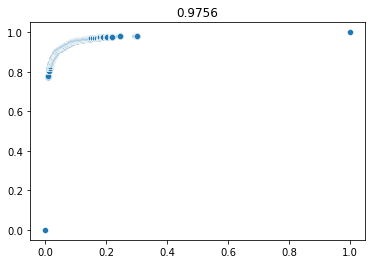

In [40]:
performance(RF_cv, rf_X_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    199320
           1       0.71      0.92      0.80     26747

    accuracy                           0.95    226067
   macro avg       0.85      0.94      0.89    226067
weighted avg       0.96      0.95      0.95    226067

[[189155  10165]
 [  2017  24730]]


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


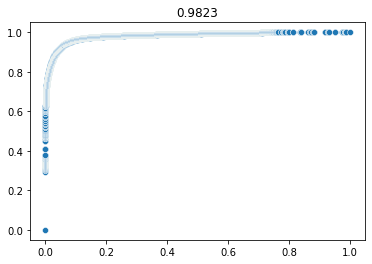

In [41]:
performance(LR_cv, log_X_test, y_test)

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    199320
           1       0.72      0.95      0.82     26747

    accuracy                           0.95    226067
   macro avg       0.86      0.95      0.90    226067
weighted avg       0.96      0.95      0.95    226067

[[189542   9778]
 [  1371  25376]]


/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


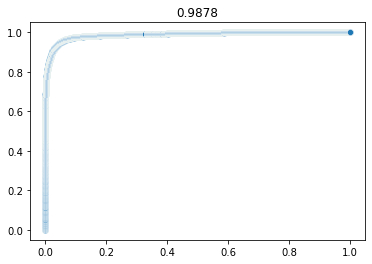

In [42]:
performance(XGboost_cv, xgb_X_test, y_test)

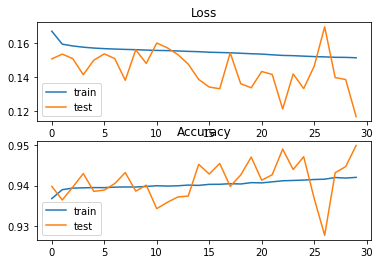

In [43]:
# evaluate the NN model
_, train_acc = model.evaluate(NN_X_train_us, NN_y_train_us, verbose=0)
_, test_acc = model.evaluate(NN_X_test, NN_y_test, verbose=0)

# plot loss during training
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='test')
plt.legend()
plt.show()

In [44]:
# Prediction accuracy
y_prob = model.predict(NN_X_test)
y_pred = np.argmax(y_prob, axis = 1)
np.unique(y_pred, return_counts = True)
print(classification_report(y_pred=y_pred, y_true= y_test))

              precision    recall  f1-score   support

           0       0.99      0.95      0.97    199320
           1       0.73      0.93      0.81     26747

    accuracy                           0.95    226067
   macro avg       0.86      0.94      0.89    226067
weighted avg       0.96      0.95      0.95    226067

